Neste case, você vai trabalhar com os algoritmos de arvore para fazer um treinamento de regressão usando ML;

* Faça a importação da base indicadores.csv e acoes.csv;
* Use a variável precoFechamento como sua variável resposta;
* Use a propria variável resposta como feature do modelo;
* Use algum método de feature selection antes do processo de modelagem;
* Use as técnicas random_forest, decision_tree e XGBoost;
* Faça uso de métricas de qualidade e ajuste para entender qual modelo performou melhor;
* Faça a serialização do modelo vencedor com joblib;
* Crie um dado de exemplo e rode o predict do modelo;
* Explique o motivo de ter usado as tecnicas de qualidade e ajuste escolhidas;
* Notou algo estranho na base de dados? Em caso positivo, deixe isso bem sinalizado;
* Demonstre que seu modelo não overfitou, se aplicavel;

In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif,mutual_info_regression

import joblib

### Ativos

In [2]:
df_ativos = pd.read_csv('ativos.csv')
df_ativos.drop(columns='Unnamed: 0', inplace=True)
df_ativos.head()

,ticker,data,precoFechamentoAjustado,precoFechamento,precoAbertura,precoMinimo,precoMaximo,precoMedio,quantidadeNegocios,quantidadeNegociada,volumeNegociado
0,BBAS3,2022-12-29,34.73,34.73,34.83,34.40,35.04,34.72,24891,9336500,324243531
1,BBAS3,2022-12-28,34.67,34.67,34.10,33.62,34.80,34.37,34386,10725200,368690829
2,BBAS3,2022-12-27,34.06,34.06,35.45,33.90,35.45,34.25,25954,8865800,303717353
3,BBAS3,2022-12-26,35.23,35.23,35.57,34.74,35.57,35.10,15236,4552700,159835769
4,BBAS3,2022-12-23,35.28,35.28,34.53,34.53,35.64,35.19,32318,8744400,307785105


In [3]:
df_ativos['data'] = pd.to_datetime(df_ativos['data'], format='%Y-%m-%d')

In [4]:
df_ativos.shape

(3730, 11)

In [5]:
df_ativos['data'].unique()[:20]

array(['2022-12-29T00:00:00.000000000', '2022-12-28T00:00:00.000000000',
       '2022-12-27T00:00:00.000000000', '2022-12-26T00:00:00.000000000',
       '2022-12-23T00:00:00.000000000', '2022-12-22T00:00:00.000000000',
       '2022-12-21T00:00:00.000000000', '2022-12-20T00:00:00.000000000',
       '2022-12-19T00:00:00.000000000', '2022-12-16T00:00:00.000000000',
       '2022-12-15T00:00:00.000000000', '2022-12-14T00:00:00.000000000',
       '2022-12-13T00:00:00.000000000', '2022-12-12T00:00:00.000000000',
       '2022-12-09T00:00:00.000000000', '2022-12-08T00:00:00.000000000',
       '2022-12-07T00:00:00.000000000', '2022-12-06T00:00:00.000000000',
       '2022-12-05T00:00:00.000000000', '2022-12-02T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [6]:
df_ativos['ticker'].unique()

array(['BBAS3', 'B3SA3', 'ITUB4', 'PETR4', 'BBDC4'], dtype=object)

In [7]:
df_ativos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3730 entries, 0 to 3729
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ticker                   3730 non-null   object        
 1   data                     3730 non-null   datetime64[ns]
 2   precoFechamentoAjustado  3730 non-null   float64       
 3   precoFechamento          3730 non-null   float64       
 4   precoAbertura            3730 non-null   float64       
 5   precoMinimo              3730 non-null   float64       
 6   precoMaximo              3730 non-null   float64       
 7   precoMedio               3730 non-null   float64       
 8   quantidadeNegocios       3730 non-null   int64         
 9   quantidadeNegociada      3730 non-null   int64         
 10  volumeNegociado          3730 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 320.7+ KB


### Indicadores

In [8]:
df_indicadores = pd.read_csv('indicadores.csv')
df_indicadores.drop(columns='Unnamed: 0', inplace=True)
df_indicadores.head()

,ticker,indicador,data,valor
0,BBAS3,ROE,2020-01-01,0.19514
1,BBAS3,ROE,2020-02-13,0.18099
2,BBAS3,ROE,2020-05-06,0.17176
3,BBAS3,ROE,2020-05-07,0.17766
4,BBAS3,ROE,2020-08-06,0.16300


In [9]:
df_indicadores = df_indicadores.pivot_table('valor', ['ticker','data'], 'indicador').reset_index()
df_indicadores.head()

indicador,ticker,data,EV,EV_EBIT,LPA,L_P,P_L,ROE,ROIC,ValorDeMercado
0,B3SA3,2020-01-01,8.376427e+10,28.23392,1.24504,0.02897,34.51282,0.10101,0.07828,8.848118e+10
1,B3SA3,2020-01-02,8.817082e+10,29.71922,NaN,0.02760,36.23164,NaN,NaN,9.288774e+10
2,B3SA3,2020-01-03,8.549394e+10,28.81694,NaN,0.02842,35.18750,NaN,NaN,9.021086e+10
3,B3SA3,2020-01-06,8.462910e+10,28.52543,NaN,0.02869,34.85016,NaN,NaN,8.934602e+10
4,B3SA3,2020-01-07,8.751190e+10,29.49712,NaN,0.02780,35.97462,NaN,NaN,9.222881e+10


In [10]:
df_indicadores.shape

(3735, 10)

In [11]:
df_indicadores['data'] = pd.to_datetime(df_indicadores['data'], format='%Y-%m-%d')

In [12]:
df_indicadores['ticker'].unique()

array(['B3SA3', 'BBAS3', 'BBDC4', 'ITUB4', 'PETR4'], dtype=object)

In [13]:
df_indicadores['data'].unique()[:20]

array(['2020-01-01T00:00:00.000000000', '2020-01-02T00:00:00.000000000',
       '2020-01-03T00:00:00.000000000', '2020-01-06T00:00:00.000000000',
       '2020-01-07T00:00:00.000000000', '2020-01-08T00:00:00.000000000',
       '2020-01-09T00:00:00.000000000', '2020-01-10T00:00:00.000000000',
       '2020-01-13T00:00:00.000000000', '2020-01-14T00:00:00.000000000',
       '2020-01-15T00:00:00.000000000', '2020-01-16T00:00:00.000000000',
       '2020-01-17T00:00:00.000000000', '2020-01-20T00:00:00.000000000',
       '2020-01-21T00:00:00.000000000', '2020-01-22T00:00:00.000000000',
       '2020-01-23T00:00:00.000000000', '2020-01-24T00:00:00.000000000',
       '2020-01-27T00:00:00.000000000', '2020-01-28T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [14]:
df_indicadores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3735 entries, 0 to 3734
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ticker          3735 non-null   object        
 1   data            3735 non-null   datetime64[ns]
 2   EV              3735 non-null   float64       
 3   EV_EBIT         3735 non-null   float64       
 4   LPA             75 non-null     float64       
 5   L_P             3735 non-null   float64       
 6   P_L             3735 non-null   float64       
 7   ROE             71 non-null     float64       
 8   ROIC            26 non-null     float64       
 9   ValorDeMercado  3735 non-null   float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 291.9+ KB


In [15]:
# Merge base de ativos e indicadores
df = pd.merge(df_ativos, df_indicadores, on=['ticker','data'], how='inner')
df.head(12)

,ticker,data,precoFechamentoAjustado,precoFechamento,precoAbertura,precoMinimo,precoMaximo,precoMedio,quantidadeNegocios,quantidadeNegociada,volumeNegociado,EV,EV_EBIT,LPA,L_P,P_L,ROE,ROIC,ValorDeMercado
0,BBAS3,2022-12-29,34.73,34.73,34.83,34.40,35.04,34.72,24891,9336500,324243531,9.951593e+10,2.59534,NaN,0.27454,3.64244,NaN,NaN,9.951593e+10
1,BBAS3,2022-12-28,34.67,34.67,34.10,33.62,34.80,34.37,34386,10725200,368690829,9.934401e+10,2.59085,NaN,0.27502,3.63615,NaN,NaN,9.934401e+10
2,BBAS3,2022-12-27,34.06,34.06,35.45,33.90,35.45,34.25,25954,8865800,303717353,9.759610e+10,2.54527,NaN,0.27994,3.57218,NaN,NaN,9.759610e+10
3,BBAS3,2022-12-26,35.23,35.23,35.57,34.74,35.57,35.10,15236,4552700,159835769,1.009486e+11,2.63270,NaN,0.27064,3.69488,NaN,NaN,1.009486e+11
4,BBAS3,2022-12-23,35.28,35.28,34.53,34.53,35.64,35.19,32318,8744400,307785105,1.010919e+11,2.63644,NaN,0.27026,3.70013,NaN,NaN,1.010919e+11
5,BBAS3,2022-12-22,34.43,34.43,34.32,33.91,34.85,34.32,24613,7398300,253942660,9.865631e+10,2.57292,NaN,0.27693,3.61098,NaN,NaN,9.865631e+10
6,BBAS3,2022-12-21,34.12,34.12,34.10,33.74,34.46,34.08,30277,8747500,298199745,9.776803e+10,2.54975,NaN,0.27945,3.57847,NaN,NaN,9.776803e+10
7,BBAS3,2022-12-20,33.80,33.80,32.94,32.63,34.16,33.78,47223,13249000,447645002,9.685110e+10,2.52584,NaN,0.28209,3.54491,NaN,NaN,9.685110e+10
8,BBAS3,2022-12-19,32.95,32.95,32.71,32.51,33.45,32.94,44625,15579000,513260088,9.441549e+10,2.46232,NaN,0.28937,3.45576,NaN,NaN,9.441549e+10
9,BBAS3,2022-12-16,32.60,32.60,32.00,31.78,32.76,32.40,43942,21848400,707937128,9.341259e+10,2.43616,NaN,0.29248,3.41905,NaN,NaN,9.341259e+10


In [16]:
df['anomes'] = df['data'].dt.year*100 + df['data'].dt.month

In [17]:
df.shape

(3730, 20)

In [18]:
# Atribuindo valores de atraso para a feature precoFechamento
df['precoFechamento_shit-1'] = df['precoFechamento'].shift(-1)
df['precoFechamento_shit-2'] = df['precoFechamento'].shift(-2)
df['precoFechamento_shit-3'] = df['precoFechamento'].shift(-3)
df['precoFechamento_shit-4'] = df['precoFechamento'].shift(-4)
df['precoFechamento_shit-5'] = df['precoFechamento'].shift(-5)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3730 entries, 0 to 3729
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ticker                   3730 non-null   object        
 1   data                     3730 non-null   datetime64[ns]
 2   precoFechamentoAjustado  3730 non-null   float64       
 3   precoFechamento          3730 non-null   float64       
 4   precoAbertura            3730 non-null   float64       
 5   precoMinimo              3730 non-null   float64       
 6   precoMaximo              3730 non-null   float64       
 7   precoMedio               3730 non-null   float64       
 8   quantidadeNegocios       3730 non-null   int64         
 9   quantidadeNegociada      3730 non-null   int64         
 10  volumeNegociado          3730 non-null   int64         
 11  EV                       3730 non-null   float64       
 12  EV_EBIT                  3730 non-

In [20]:
df = df.dropna(thresh=df.shape[0]*0.5,how='all',axis=1)

In [21]:
df = df.dropna(axis=0)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3725 entries, 0 to 3724
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ticker                   3725 non-null   object        
 1   data                     3725 non-null   datetime64[ns]
 2   precoFechamentoAjustado  3725 non-null   float64       
 3   precoFechamento          3725 non-null   float64       
 4   precoAbertura            3725 non-null   float64       
 5   precoMinimo              3725 non-null   float64       
 6   precoMaximo              3725 non-null   float64       
 7   precoMedio               3725 non-null   float64       
 8   quantidadeNegocios       3725 non-null   int64         
 9   quantidadeNegociada      3725 non-null   int64         
 10  volumeNegociado          3725 non-null   int64         
 11  EV                       3725 non-null   float64       
 12  EV_EBIT                  3725 non-

In [23]:
df.head()

,ticker,data,precoFechamentoAjustado,precoFechamento,precoAbertura,precoMinimo,precoMaximo,precoMedio,quantidadeNegocios,quantidadeNegociada,...,EV_EBIT,L_P,P_L,ValorDeMercado,anomes,precoFechamento_shit-1,precoFechamento_shit-2,precoFechamento_shit-3,precoFechamento_shit-4,precoFechamento_shit-5
0,BBAS3,2022-12-29,34.73,34.73,34.83,34.40,35.04,34.72,24891,9336500,...,2.59534,0.27454,3.64244,9.951593e+10,202212,34.67,34.06,35.23,35.28,34.43
1,BBAS3,2022-12-28,34.67,34.67,34.10,33.62,34.80,34.37,34386,10725200,...,2.59085,0.27502,3.63615,9.934401e+10,202212,34.06,35.23,35.28,34.43,34.12
2,BBAS3,2022-12-27,34.06,34.06,35.45,33.90,35.45,34.25,25954,8865800,...,2.54527,0.27994,3.57218,9.759610e+10,202212,35.23,35.28,34.43,34.12,33.80
3,BBAS3,2022-12-26,35.23,35.23,35.57,34.74,35.57,35.10,15236,4552700,...,2.63270,0.27064,3.69488,1.009486e+11,202212,35.28,34.43,34.12,33.80,32.95
4,BBAS3,2022-12-23,35.28,35.28,34.53,34.53,35.64,35.19,32318,8744400,...,2.63644,0.27026,3.70013,1.010919e+11,202212,34.43,34.12,33.80,32.95,32.60


In [24]:
df['data'].max(), df['data'].min()

(Timestamp('2022-12-29 00:00:00'), Timestamp('2020-01-02 00:00:00'))

In [25]:
df.dtypes

ticker                             object
data                       datetime64[ns]
precoFechamentoAjustado           float64
precoFechamento                   float64
precoAbertura                     float64
precoMinimo                       float64
precoMaximo                       float64
precoMedio                        float64
quantidadeNegocios                  int64
quantidadeNegociada                 int64
volumeNegociado                     int64
EV                                float64
EV_EBIT                           float64
L_P                               float64
P_L                               float64
ValorDeMercado                    float64
anomes                              int64
precoFechamento_shit-1            float64
precoFechamento_shit-2            float64
precoFechamento_shit-3            float64
precoFechamento_shit-4            float64
precoFechamento_shit-5            float64
dtype: object

* Notou algo estranho na base de dados? Em caso positivo, deixe isso bem sinalizado; <br>
Avaliar a base indicadores possui a coluna indicador que ao fazer o merge causaria duplicidade de dados<br>
Importante utilizar o pivot table para transformar linhas em colunas<br>

## EDA

Observar comportamento da variável resposta para diferentes features do modelo ao longo do tempo

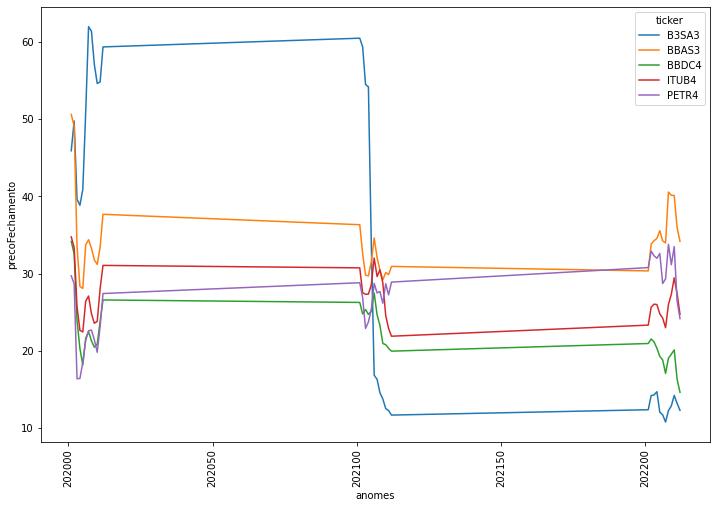

In [26]:
## Variáveis categóricas
df_aux = df.groupby(['anomes', 'ticker'], as_index=False).mean()
fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(x='anomes', y='precoFechamento', data=df_aux, hue='ticker')
plt.xticks(rotation=90)
plt.show()

In [27]:
def histogram(col):
    df[col].hist(bins=50)
    plt.show()
    
def boxplot(col):
    df.boxplot(column=[col], by=['anomes'], showfliers=False, figsize=(20,5), rot=90)
    plt.show()

precoFechamentoAjustado


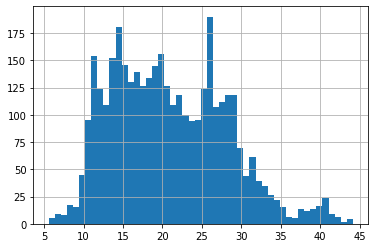

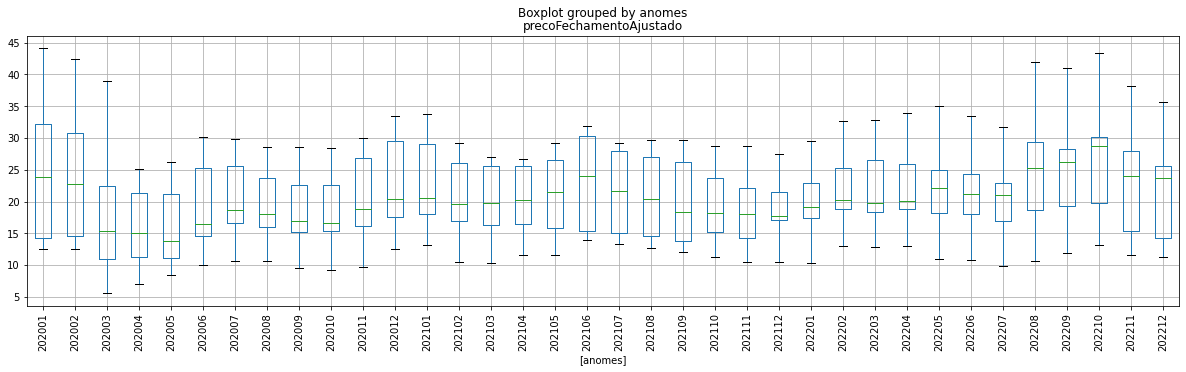

precoFechamento


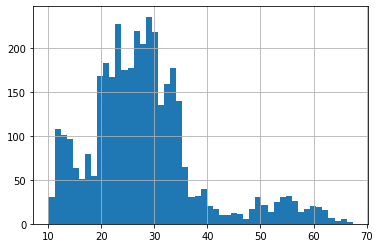

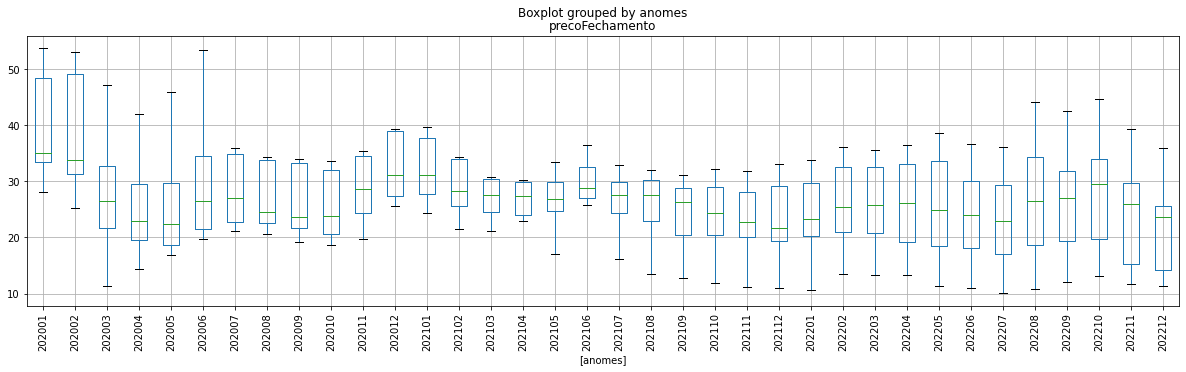

precoAbertura


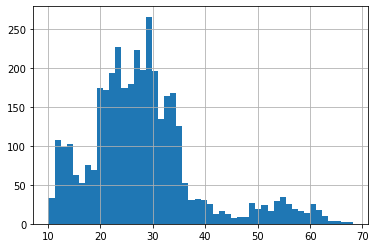

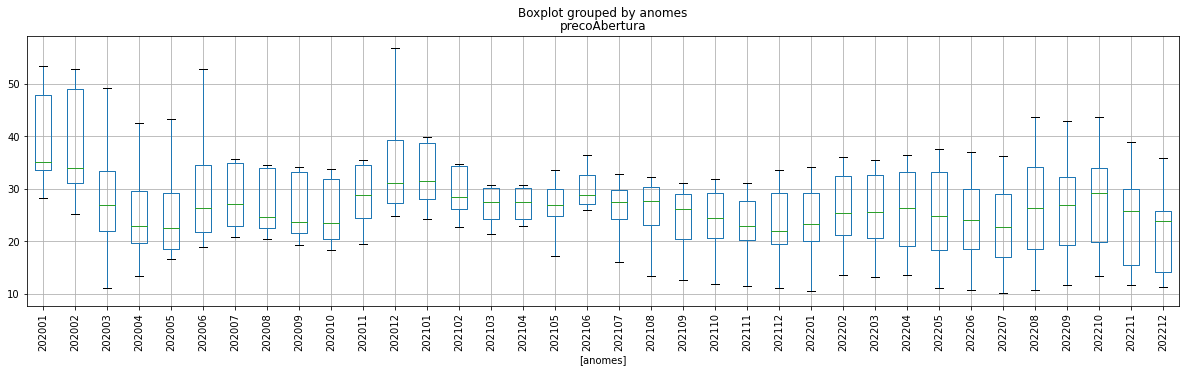

precoMinimo


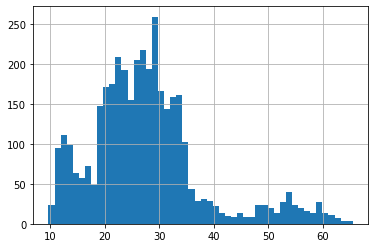

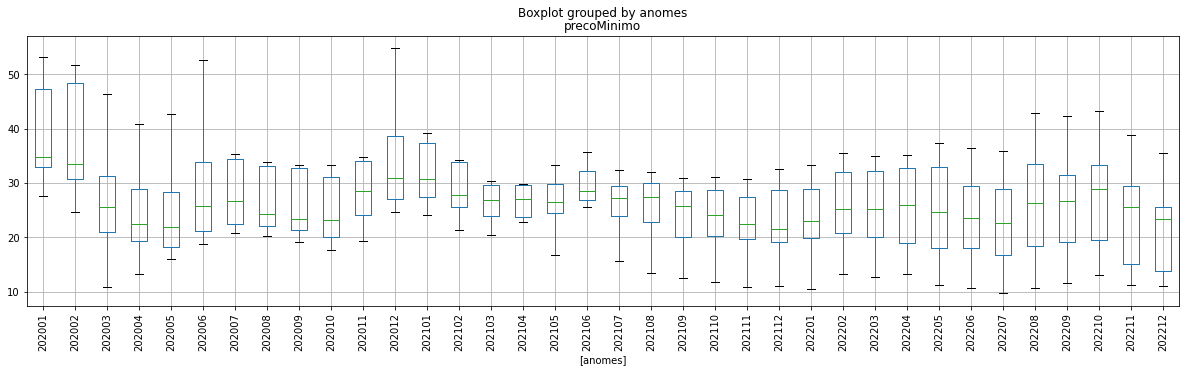

precoMaximo


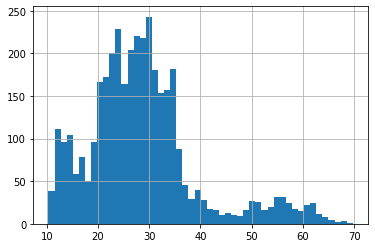

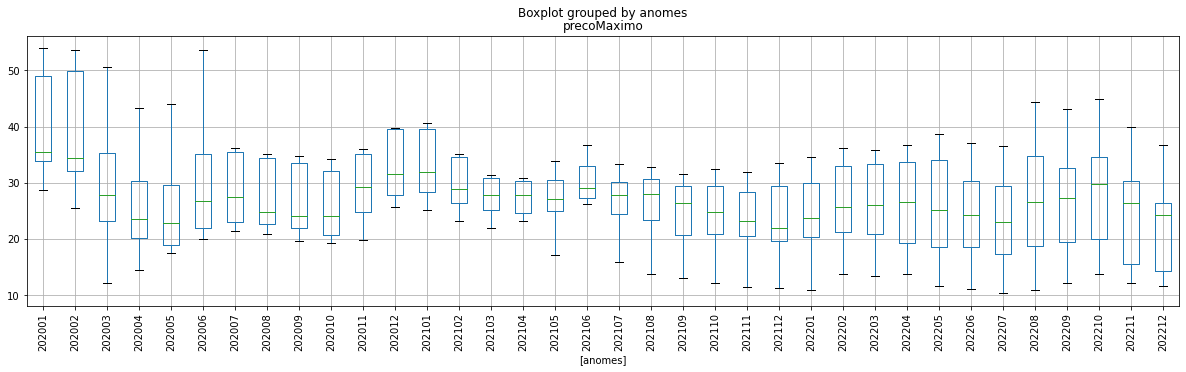

precoMedio


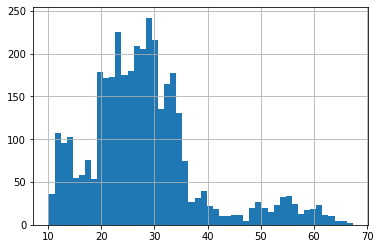

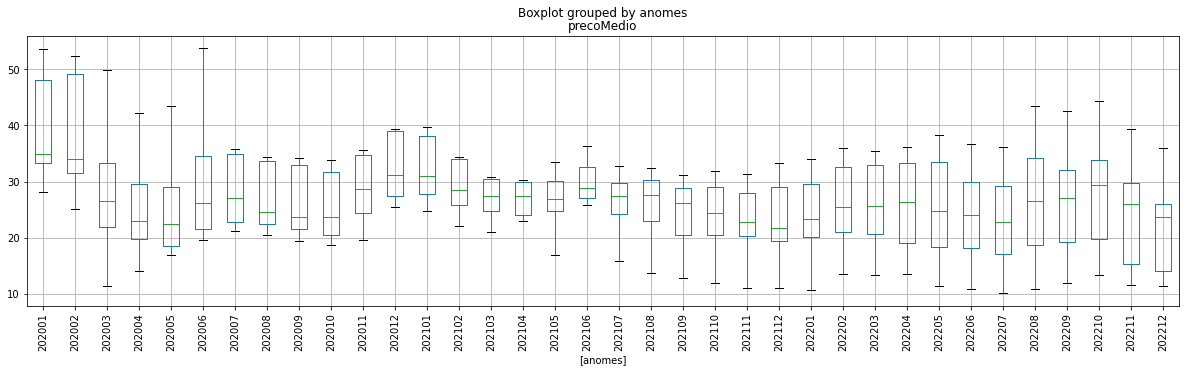

quantidadeNegocios


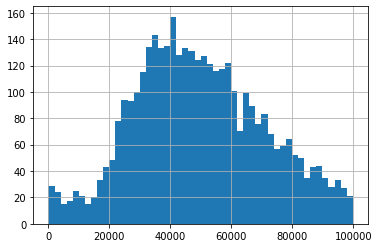

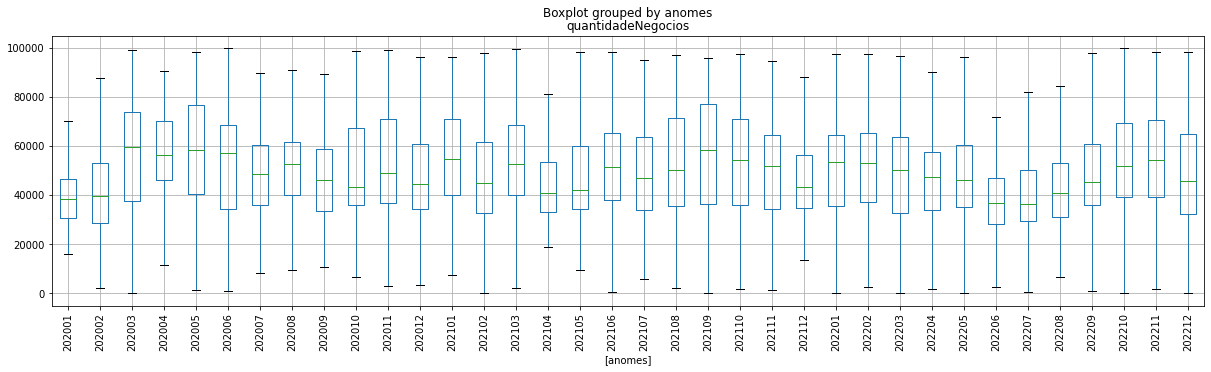

quantidadeNegociada


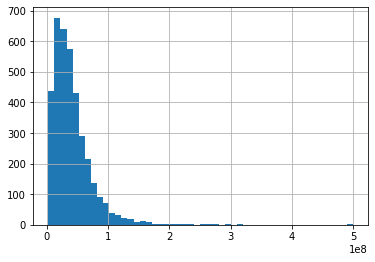

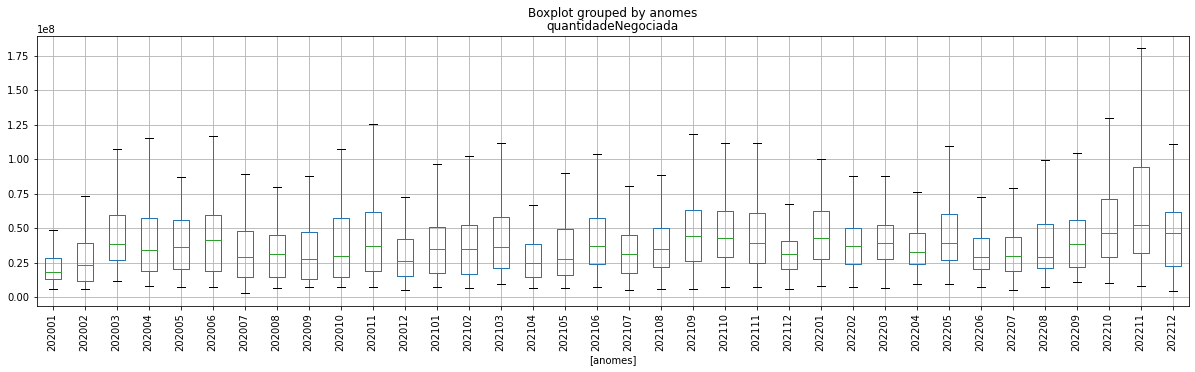

volumeNegociado


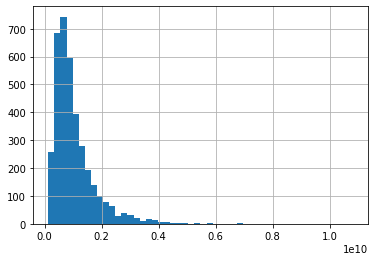

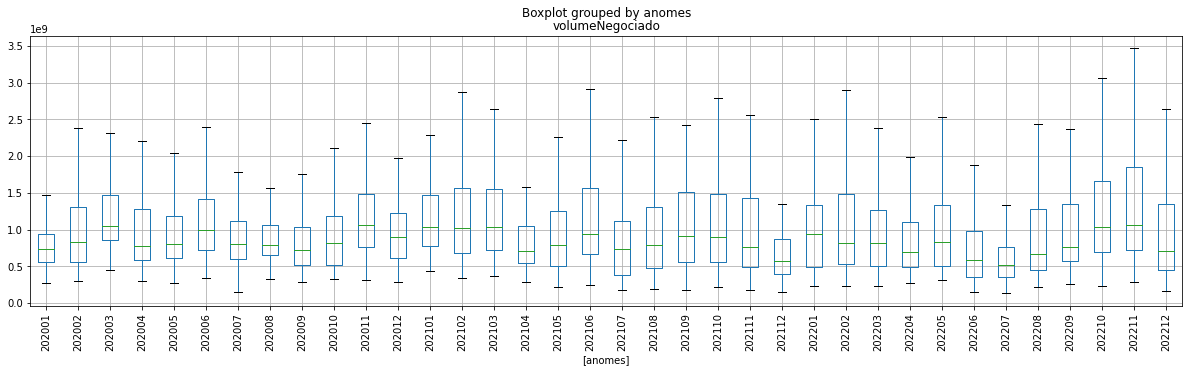

EV


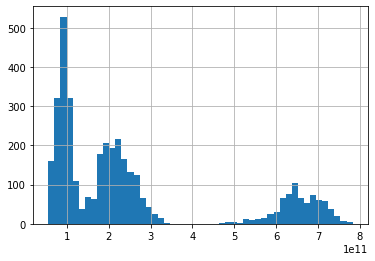

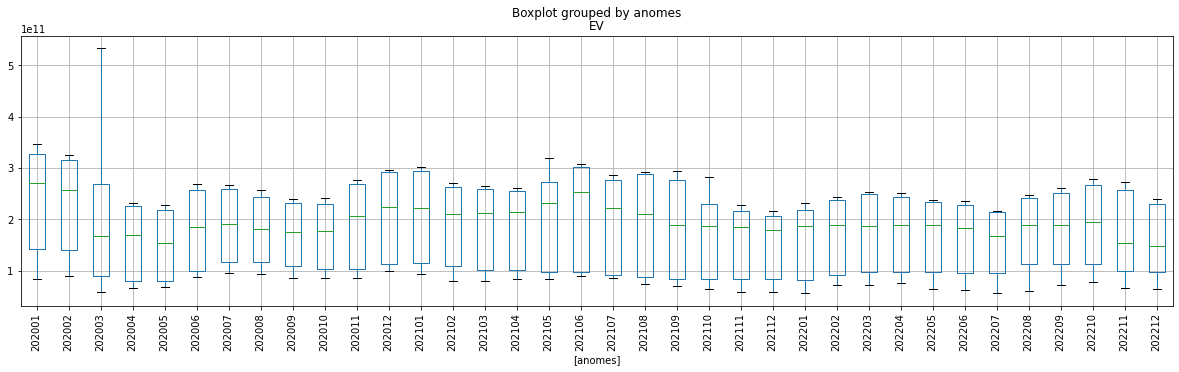

EV_EBIT


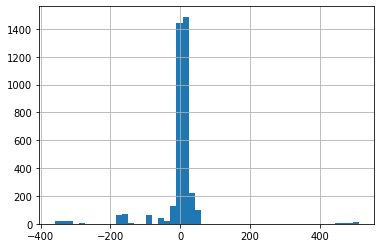

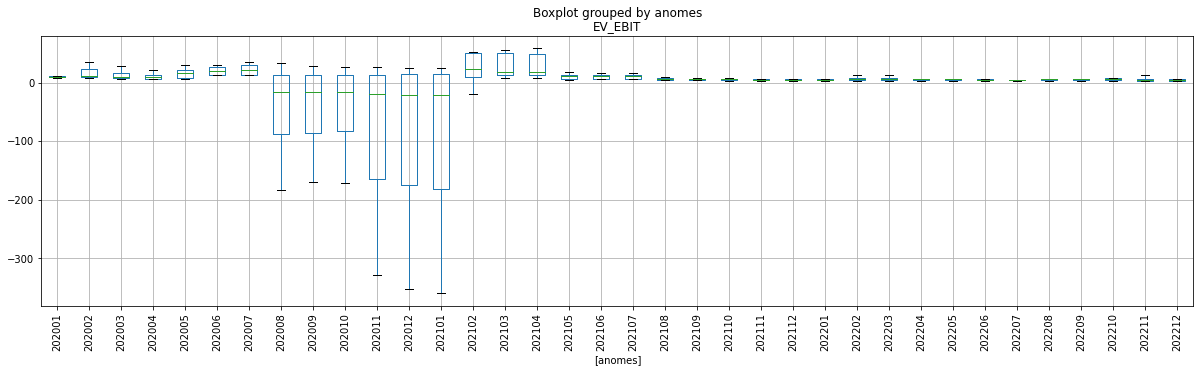

L_P


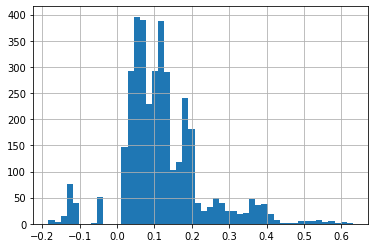

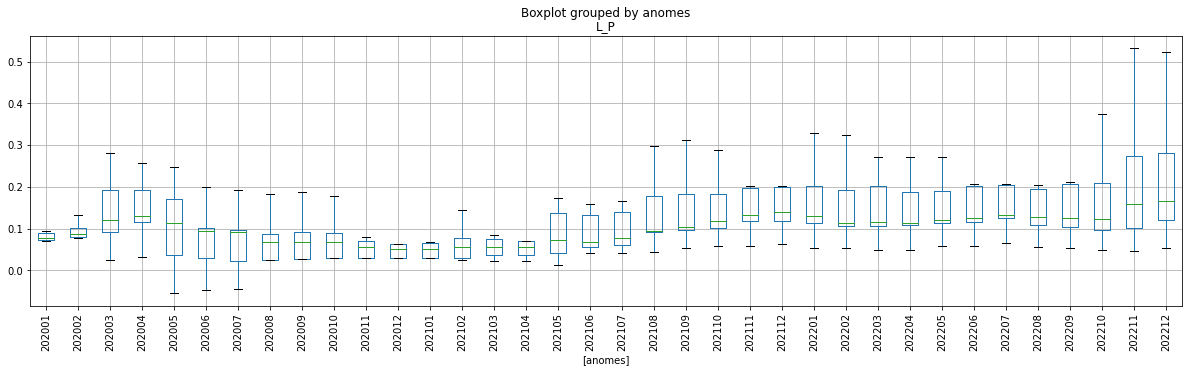

P_L


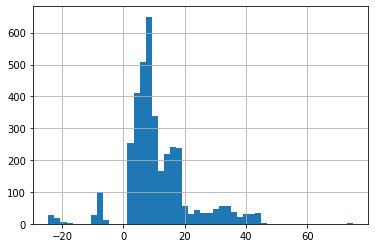

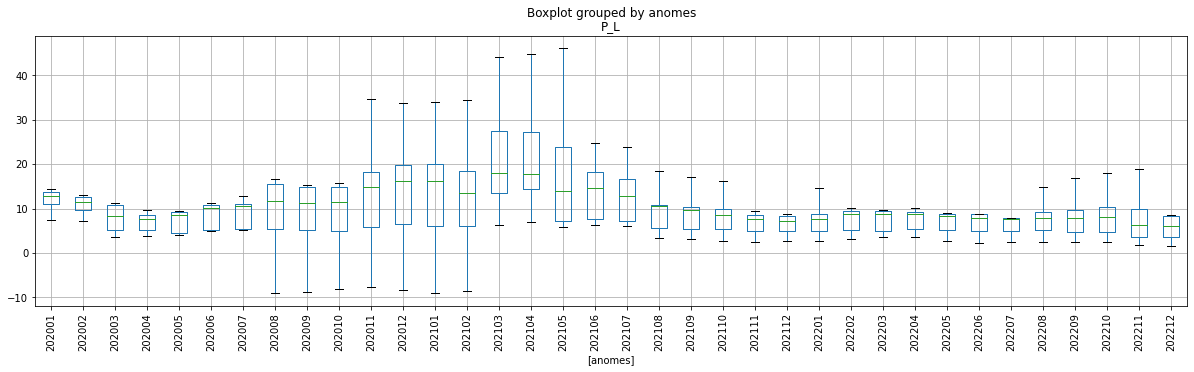

ValorDeMercado


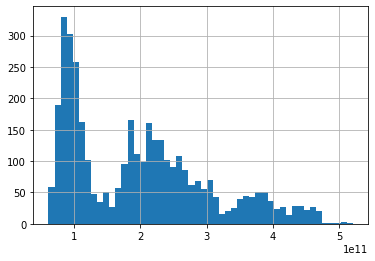

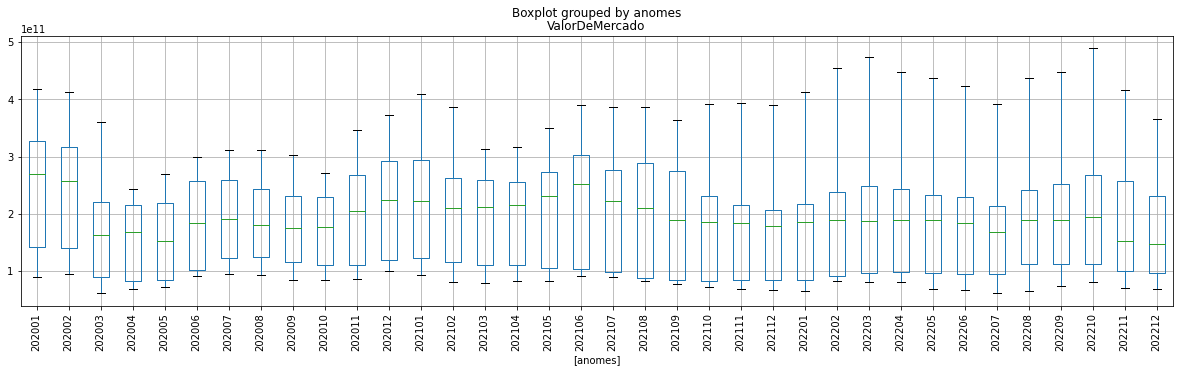

precoFechamento_shit-1


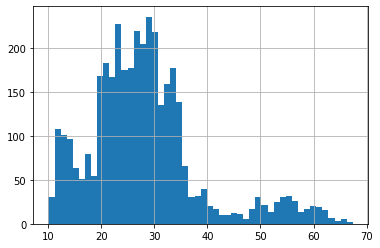

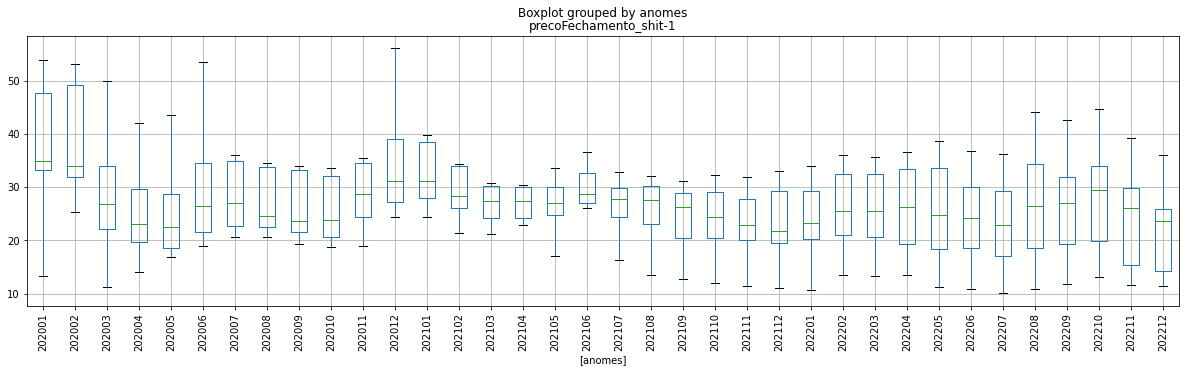

precoFechamento_shit-2


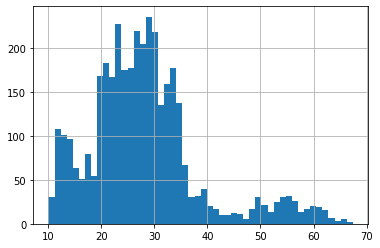

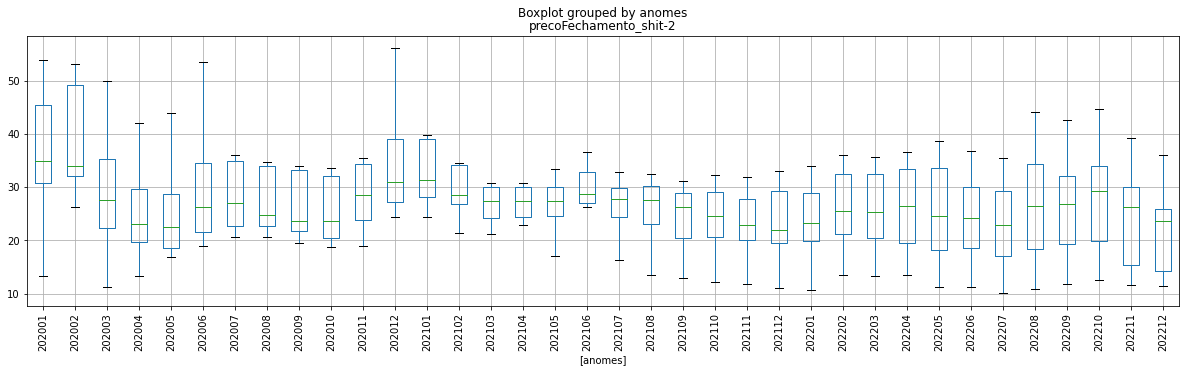

precoFechamento_shit-3


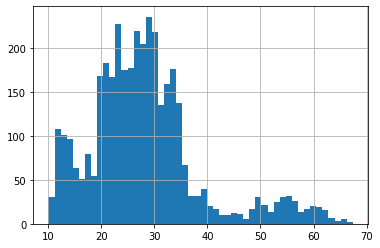

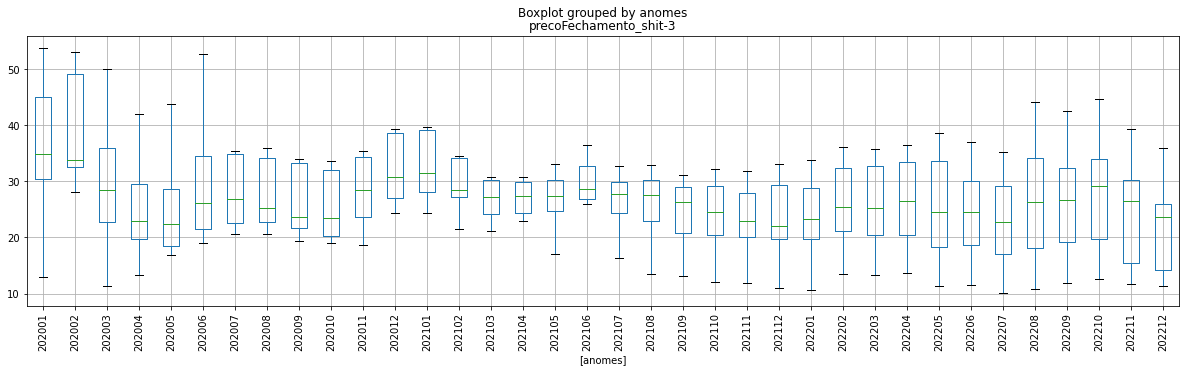

precoFechamento_shit-4


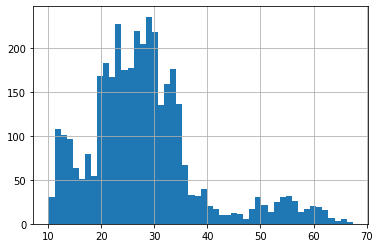

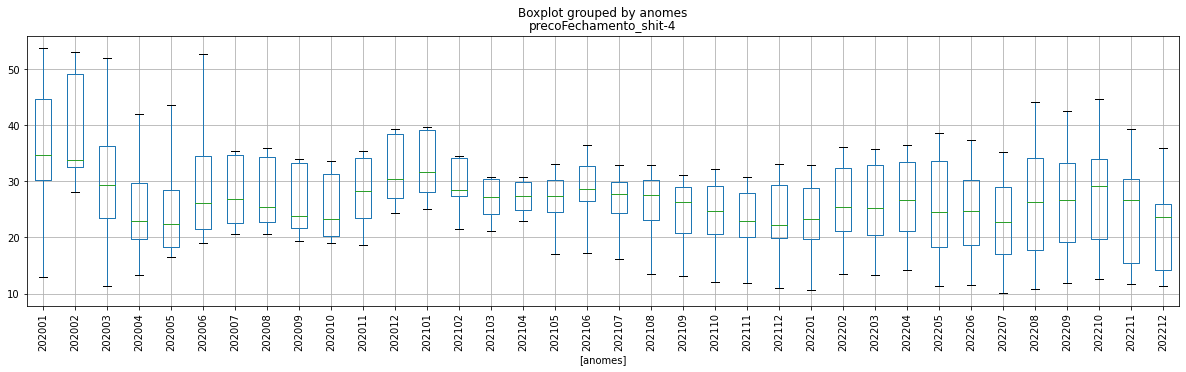

precoFechamento_shit-5


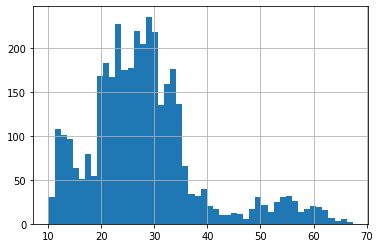

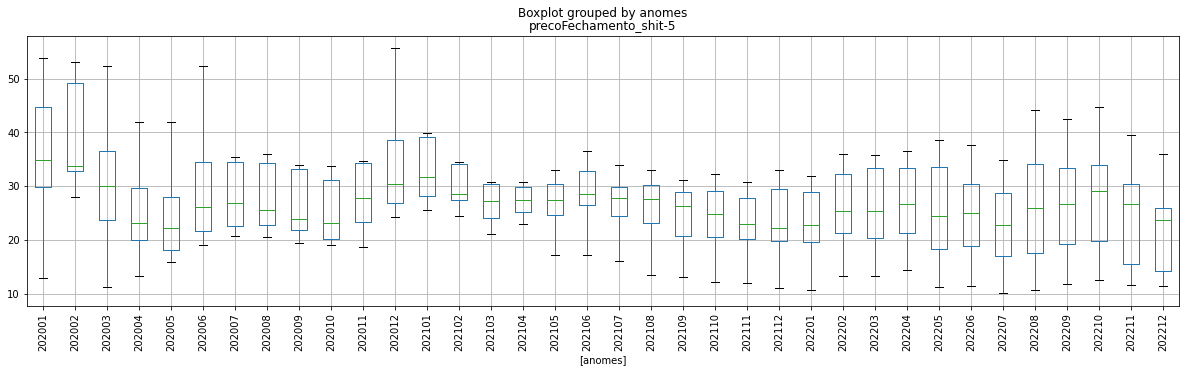

In [28]:
for col in df.columns:
    if is_numeric_dtype(df[col]) and col != 'anomes':
        print(col)
        histogram(col)
        boxplot(col)

## Análise Multivariada

In [29]:
def analise_multivariada(col1):
    sns.scatterplot(df, x=col1, y='precoFechamento')
    plt.show()

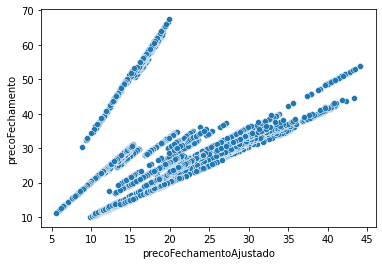

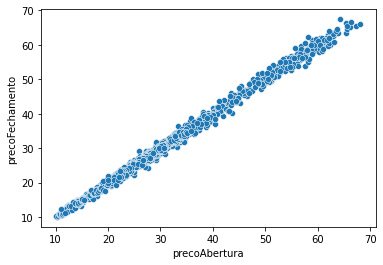

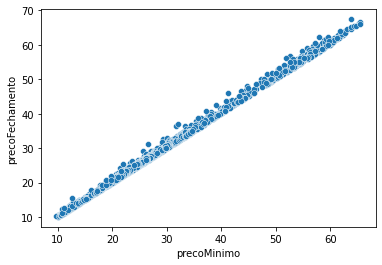

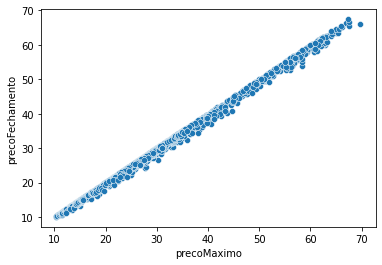

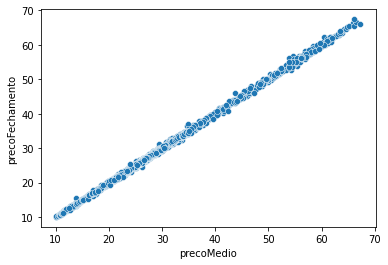

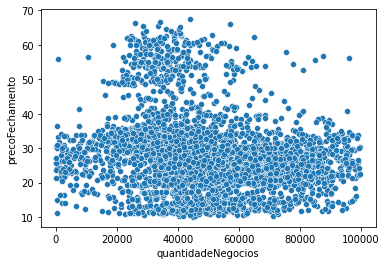

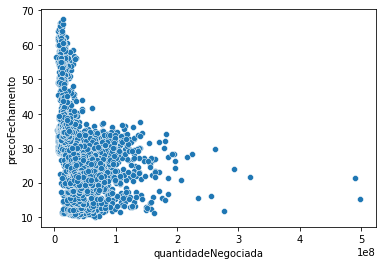

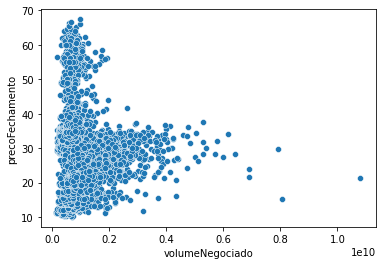

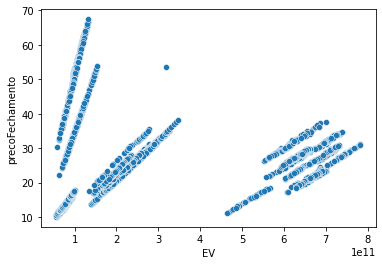

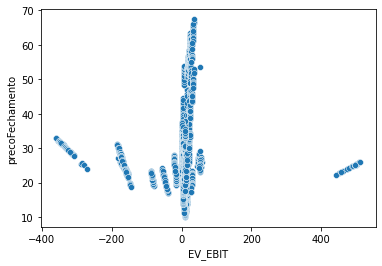

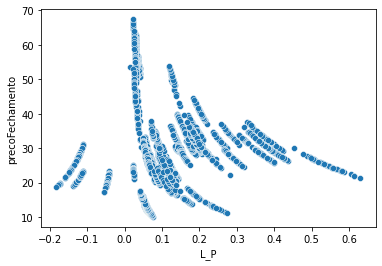

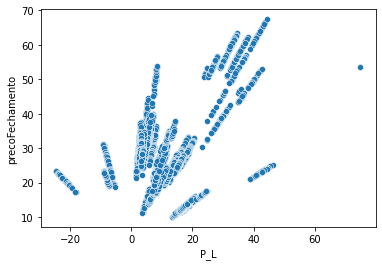

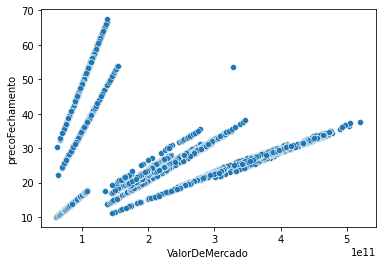

In [30]:
lista_col = ['precoFechamentoAjustado','precoAbertura', 'precoMinimo', 'precoMaximo', 'precoMedio','quantidadeNegocios', 'quantidadeNegociada', 'volumeNegociado', 'EV', 'EV_EBIT', 'L_P', 'P_L', 'ValorDeMercado']
for i in lista_col:
    analise_multivariada(i)

## Treino e Teste
Separação entre treino, validação e teste

In [32]:
df.set_index(['ticker', 'data', 'anomes'], inplace=True)

In [33]:
X = df[df.columns[df.columns != 'precoFechamento']]
y = df['precoFechamento']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.1)

## Correlação dos dados

In [36]:
def correlation(corr_matrix):

    plt.figure(figsize=(10,10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns.values,
               yticklabels=corr_matrix.columns.values, cmap=cmap, vmax=1, center=0, square=True, annot=True, linewidths=.5, cbar_kws={'shrink':.82})
    plt.title('Heatmap of correlation matrix')

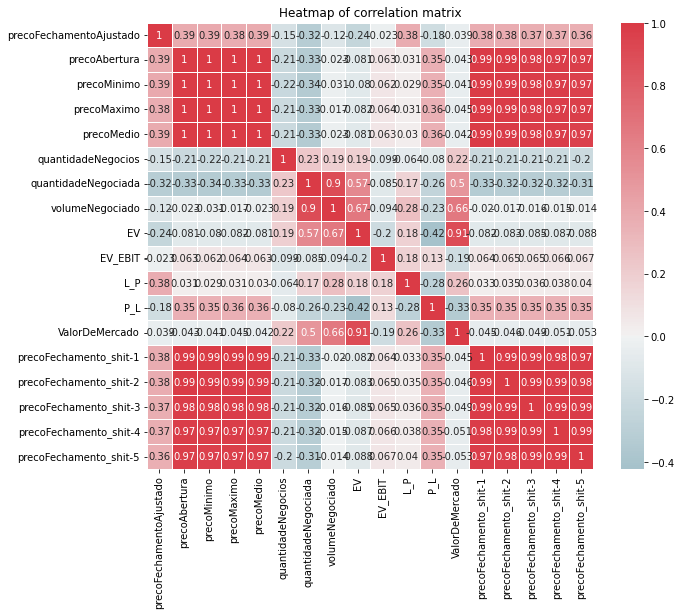

In [37]:
correlation(X_train.corr())

## Feature Selection

### SelectKBest

In [40]:
selector = SelectKBest(mutual_info_regression, k=10)
selector.fit(X_train, y_train)

selector.get_support()

array([ True,  True,  True,  True,  True, False, False, False,  True,
       False,  True,  True,  True,  True, False, False, False, False])

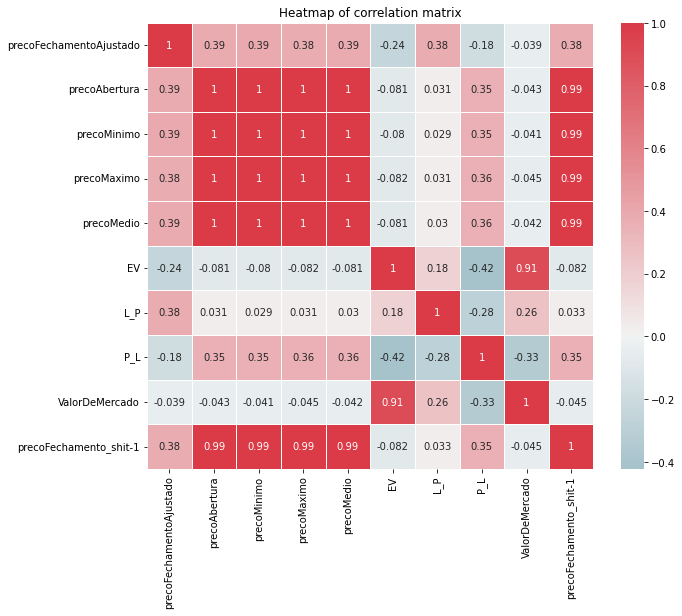

In [41]:
correlation(X_train[X_train.columns[selector.get_support()]].corr())

### RFE

In [42]:
# Crie o classificador base
clf = RandomForestRegressor(random_state=42, min_samples_leaf=0.2, max_depth=8)
rfe = RFE(estimator=clf, n_features_to_select=9)
rfe.fit(X_train, y_train)

# Obtenha os recursos selecionados
selected_features = X_train.columns[rfe.support_]
selected_features

Index(['precoMinimo', 'precoMaximo', 'precoMedio', 'ValorDeMercado',
       'precoFechamento_shit-1', 'precoFechamento_shit-2',
       'precoFechamento_shit-3', 'precoFechamento_shit-4',
       'precoFechamento_shit-5'],
      dtype='object')

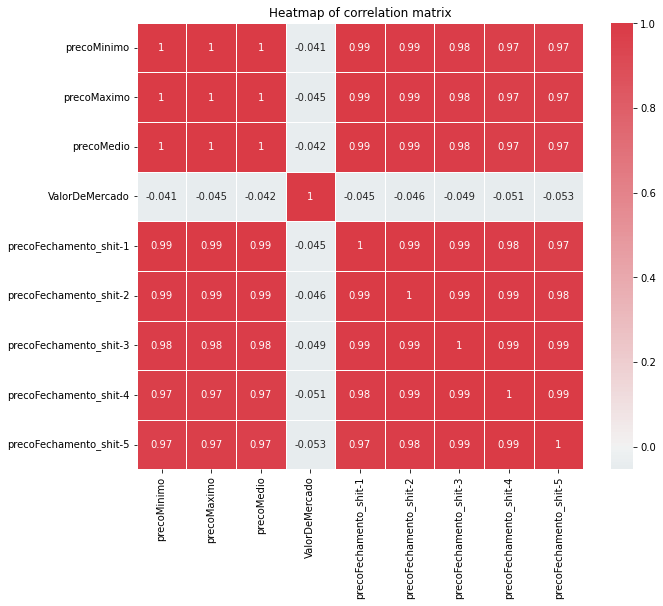

In [43]:
correlation(X_train[selected_features].corr())

### Correlação

In [45]:
corr = X_train.corr()
features = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.7).any()
features

precoFechamentoAjustado     True
precoAbertura              False
precoMinimo                False
precoMaximo                False
precoMedio                 False
quantidadeNegocios          True
quantidadeNegociada        False
volumeNegociado            False
EV                         False
EV_EBIT                     True
L_P                         True
P_L                         True
ValorDeMercado             False
precoFechamento_shit-1     False
precoFechamento_shit-2     False
precoFechamento_shit-3     False
precoFechamento_shit-4     False
precoFechamento_shit-5     False
dtype: bool

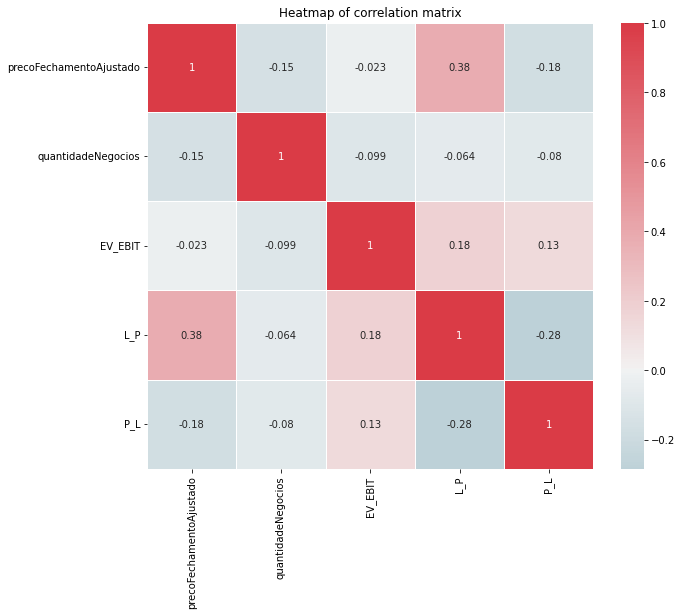

In [47]:
# Avaliando após seleção de features
aux = X_train.loc[:,list(features.values)]
correlation(aux.corr())

In [48]:
X_train_sample = X_train.loc[:,list(features.values)]
X_test_sample = X_test.loc[:,list(features.values)]

In [49]:
X_test_sample.head()

precoFechamentoAjustado  quantidadeNegocios  \
ticker data       anomes                                                
BBAS3  2020-10-06 202010                    25.30               25468   
BBDC4  2021-06-10 202106                    24.26               37225   
       2020-07-09 202007                    16.84               69108   
PETR4  2021-04-14 202104                    12.00               68293   
B3SA3  2020-05-07 202005                    10.88               58614   

                           EV_EBIT      L_P       P_L  
ticker data       anomes                               
BBAS3  2020-10-06 202010  11.35456  0.19891   5.02728  
BBDC4  2021-06-10 202106  11.83476  0.06775  14.76089  
       2020-07-09 202007 -51.41624  0.09622  10.39246  
PETR4  2021-04-14 202104  12.98220  0.02238  44.68676  
B3SA3  2020-05-07 202005  21.89656  0.03577  27.95675

Foi utilizado a técnica de correlação para seleção das variáveis: EV_EBIT, L_P, P_L,precoFechamentoAjustado,	quantidadeNegocios

## Modelagem

In [50]:
#Treino e Validação
X_train2, X_val, y_train2, y_val = train_test_split(X_train_sample, y_train, random_state=42,
                                                        test_size=0.2)

## Árvore de decisão

In [51]:
dt = DecisionTreeRegressor(max_depth=8, random_state=16) # max_depth como default causa overffiting
dt = dt.fit(X_train2,y_train2)

y_pred_train = dt.predict(X_train2)
y_pred_test  = dt.predict(X_val)

In [52]:
print('MSE treino: ', mean_squared_error(y_train2, y_pred_train))
print('MSE validação: ', mean_squared_error(y_val, y_pred_test))

print('MAE treino: ', mean_absolute_error(y_train2, y_pred_train))
print('MAE validação: ', mean_absolute_error(y_val, y_pred_test))

MSE treino:  1.0666318190781343
MSE validação:  2.862852477488401
MAE treino:  0.6103020459004387
MAE validação:  0.730438566380422


Sem determinar profundidade, gerando overfitting:<br>
MSE treino:  0.0 <br>
MSE validação:  0.8928322916666668 <br>
MAE treino:  0.0<br>
MAE validação:  0.27453869047619045<br>

## Random Forest

In [53]:
rf = RandomForestRegressor(max_depth=8, random_state=16) # max_depth como default causa overffiting
rf = rf.fit(X_train2,y_train2)

y_pred_train = rf.predict(X_train2)
y_pred_test  = rf.predict(X_val)

In [54]:
print('MSE treino: ', mean_squared_error(y_train2, y_pred_train))
print('MSE validação: ', mean_squared_error(y_val, y_pred_test))

print('MAE treino: ', mean_absolute_error(y_train2, y_pred_train))
print('MAE validação: ', mean_absolute_error(y_val, y_pred_test))

MSE treino:  1.1497268931481932
MSE validação:  2.8953905510693354
MAE treino:  0.5944852474936445
MAE validação:  0.7213718704044687


## XGBoost

In [55]:
xg = RandomForestRegressor(max_depth=8, random_state=16) # max_depth como default causa overffiting
xg = xg.fit(X_train2,y_train2)

y_pred_train = xg.predict(X_train2)
y_pred_test  = xg.predict(X_val)

In [56]:
print('MSE treino: ', mean_squared_error(y_train2, y_pred_train))
print('MSE validação: ', mean_squared_error(y_val, y_pred_test))

print('MAE treino: ', mean_absolute_error(y_train2, y_pred_train))
print('MAE validação: ', mean_absolute_error(y_val, y_pred_test))

MSE treino:  1.1497268931481932
MSE validação:  2.8953905510693354
MAE treino:  0.5944852474936445
MAE validação:  0.7213718704044687


In [57]:
# Feature Importance
feat_dict= {}
for col, val in sorted(zip(X_train2.columns, rf.feature_importances_),key=lambda x:x[1],reverse=True):
  feat_dict[col]=val

In [58]:
feat_df = pd.DataFrame({'Feature':feat_dict.keys(),'Importance':feat_dict.values()})
feat_df

,Feature,Importance
0,P_L,0.519015
1,precoFechamentoAjustado,0.421072
2,L_P,0.035768
3,EV_EBIT,0.019161
4,quantidadeNegocios,0.004985


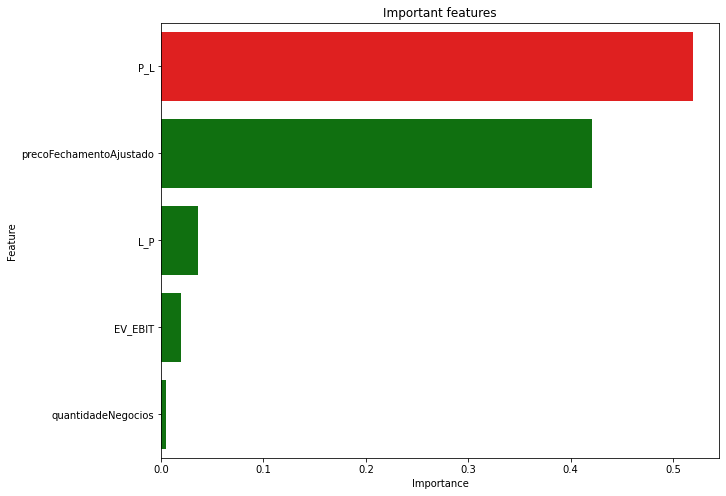

In [59]:
values = feat_df.Importance    
idx = feat_df.Feature
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features')
plt.show()

### Salvando o modelo vencedor

In [60]:
# Modelo vencedor 
import joblib

filename = "rf_model.joblib"

# save model
joblib.dump(rf, filename)

['rf_model.joblib']

#### Construindo exemplo

In [61]:
y_pred  = rf.predict(X_test_sample)

In [62]:
print('MSE teste: ', mean_squared_error(y_test, y_pred))
print('MAE teste: ', mean_absolute_error(y_test, y_pred))

MSE teste:  1.6050251824337256
MAE teste:  0.6335909493802435


Com a base de teste houve uma queda no MSE (2.8 para 1.6) e MAE (0.72 para 0.63). 